# IE4483 Project 2 — Dogs vs Cats (Small-Subset Test)
This notebook trains a small CNN using only **1000 training images** and **200 validation images**  
to verify that the data pipeline and model work correctly before scaling up.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil

2025-11-11 20:43:16.365428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 20:43:16.455971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-11 20:43:16.456035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-11 20:43:16.458230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-11 20:43:16.473675: I tensorflow/core/platform/cpu_feature_guar

### Step 1: Create a lightweight subset (1000 train, 200 val)
We copy a small random selection of images from the full dataset so that training runs quickly.

Please just run one time inside the utilities notebook.


### Step 2: Load images with `ImageDataGenerator`
We use Keras data generators to automatically:
- Resize all images to 128×128 pixels  
- Normalize pixel values to [0, 1]  
- Apply light augmentation (rotation, shifts, flips)


Found 1000 files belonging to 2 classes.


2025-11-11 20:43:31.354808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-11 20:43:31.457568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-11 20:43:31.457791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-11 20:43:31.457808: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-11-11 20:43:31.465735: I external/lo

Found 200 files belonging to 2 classes.
✅ Classes: ['cat', 'dog']


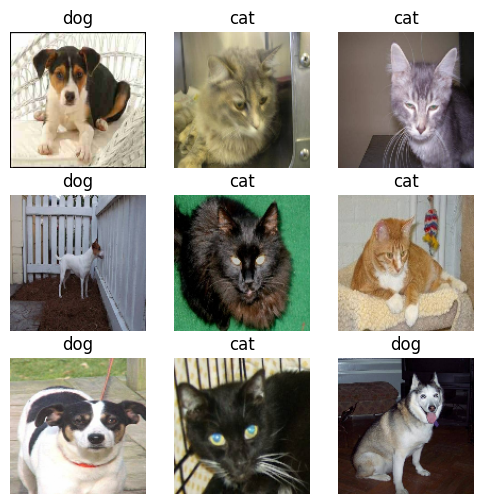

✅ Dataset ready!
Training batches: 32, approx. 1024 images
Validation batches: 7, approx. 224 images


In [2]:
# =============================================
# 🧠 IMPORTS & CONFIG
# =============================================
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Hide non-critical TF logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Dataset base folder (adjust if needed)
BASE_DIR = "../datasets_small"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

# Image / batch settings
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
SEED       = 42

# =============================================
# 📦 LOAD DATASETS (TF 2.x API)
# =============================================

# --- Training dataset ---
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",        # 0=cat, 1=dog
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True, #prevent conditions like all cats then dogs, prevent bias
    seed=SEED
)

# --- Validation dataset ---
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Save class names before further processing
class_names = train_ds_raw.class_names
print("✅ Classes:", class_names)

# =============================================
# 🧩 NORMALIZATION & PIPELINE OPTIMIZATION
# =============================================

def normalize_images(x, y):
    """Convert to float32 and scale to [0,1]."""
    return tf.cast(x, tf.float32) / 255.0, y

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# =============================================
# 🔍 OPTIONAL VISUALIZATION
# =============================================
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

# =============================================
# ✅ SUMMARY
# =============================================
num_train = tf.data.experimental.cardinality(train_ds_raw).numpy() * BATCH_SIZE
num_val   = tf.data.experimental.cardinality(val_ds_raw).numpy() * BATCH_SIZE

print(f"✅ Dataset ready!")
print(f"Training batches: {num_train // BATCH_SIZE}, approx. {num_train} images")
print(f"Validation batches: {num_val // BATCH_SIZE}, approx. {num_val} images")


### Step 3: Define a simple CNN
We start with three convolutional blocks followed by fully-connected layers.


In [3]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### Step 4: Compile and train the model
We use:
- **Binary cross-entropy** loss for two classes  
- **Adam** optimizer for adaptive learning rate  
We’ll train for 10 epochs to check convergence.


In [4]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


2025-11-11 20:43:44.923943: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-11-11 20:43:45.380356: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-11-11 20:43:45.385757: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: /home/yh/tf_gpu/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-11-11 20:43:46.651528: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-11-11 20:43:46.974087: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile

32/32 [==============================] - 10s 68ms/step - loss: 0.7126 - accuracy: 0.5190 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 1s 29ms/step - loss: 0.6893 - accuracy: 0.5460 - val_loss: 0.6861 - val_accuracy: 0.5300
Epoch 3/10
32/32 [==============================] - 1s 29ms/step - loss: 0.6766 - accuracy: 0.5860 - val_loss: 0.6672 - val_accuracy: 0.6200
Epoch 4/10
32/32 [==============================] - 1s 29ms/step - loss: 0.6548 - accuracy: 0.6270 - val_loss: 0.6691 - val_accuracy: 0.6100
Epoch 5/10
32/32 [==============================] - 1s 29ms/step - loss: 0.6266 - accuracy: 0.6640 - val_loss: 0.6418 - val_accuracy: 0.6350
Epoch 6/10
32/32 [==============================] - 1s 29ms/step - loss: 0.5832 - accuracy: 0.7060 - val_loss: 0.6681 - val_accuracy: 0.5950
Epoch 7/10
32/32 [==============================] - 1s 29ms/step - loss: 0.5568 - accuracy: 0.7160 - val_loss: 0.6439 - val_accuracy: 0.6200
Epoch 8/10
32/32 [=====

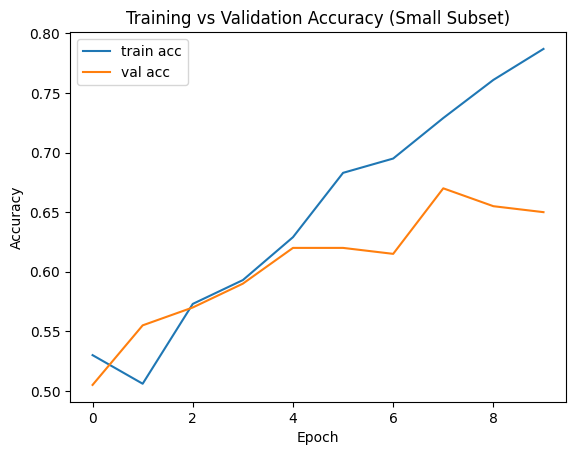

In [16]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Small Subset)')
plt.show()


### Step 5: Save the trained model
We’ll store the baseline model for later improvement (e.g., with batch normalization or pretrained networks).


In [5]:
os.makedirs("../deeplearning/models", exist_ok=True)
model.save("../deeplearning/models/cnn_baseline_small.h5")
print("✅ Model saved successfully!")


/home/yh/tf_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved successfully!
